In [1]:
#1
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

df = pd.read_parquet("custom_features_dataset.parquet")

print(df.shape)
print(df.columns)
print(df.loc[1])

(32377064, 17)
Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')
Timestamp                  2018-02-16 12:38:45.787171
Src IP                                   172.31.66.26
Dst IP                                  23.219.88.169
Bwd Packet Length Min                               0
Protocol_6                                       True
Bwd Packets/s                                0.133515
FWD Init Win Bytes                               8192
Packet Length Std                          113.214348
FIN Flag Count                                      0
SrcPortRange_registered                         False
Packet Length Min                                   0
Fwd Seg Size Min  

In [2]:
EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
LABEL_COL = "target"
ID_COLS = ['Src IP', 'Dst IP', 'Timestamp']

# Keep relevant columns only
cols = EDGE_COLS + ID_COLS + [LABEL_COL]
df = df[cols].dropna(subset=[LABEL_COL])
print(df.shape)
print(df.columns)

(32377064, 17)
Index(['Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s',
       'FWD Init Win Bytes', 'Packet Length Std', 'FIN Flag Count',
       'SrcPortRange_registered', 'Packet Length Min', 'Fwd Seg Size Min',
       'DstPortRange_well_known', 'Bwd IAT Total', 'SYN Flag Count',
       'Bwd Packet Length Std', 'Src IP', 'Dst IP', 'Timestamp', 'target'],
      dtype='object')


In [3]:
# class balance (raw flows)
print("Label counts (raw flows):\n", df[LABEL_COL].value_counts())

# quick numeric statistics
display(df[EDGE_COLS].describe().T)

Label counts (raw flows):
 target
0    28806140
1     3570924
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
Bwd Packet Length Min,32377064.0,4.000118e+01,5.759716e+01,0.0,0.000000,0.000000,7.300000e+01,1.460000e+03
Bwd Packets/s,32377064.0,5.474830e+03,5.691405e+04,0.0,2.190746,28.742713,8.149959e+02,2.000000e+06
FWD Init Win Bytes,32377064.0,8.266935e+03,1.382669e+04,0.0,0.000000,8192.000000,8.192000e+03,6.553500e+04
Packet Length Std,32377064.0,1.735210e+02,2.159001e+02,0.0,22.627417,73.070452,3.047991e+02,2.560800e+04
FIN Flag Count,32377064.0,6.180524e-01,9.025266e-01,0.0,0.000000,0.000000,2.000000e+00,1.800000e+01
Packet Length Min,32377064.0,1.616833e+01,2.326994e+01,0.0,0.000000,0.000000,3.700000e+01,1.460000e+03
Fwd Seg Size Min,32377064.0,1.630525e+01,7.745168e+00,0.0,8.000000,20.000000,2.000000e+01,5.200000e+01
Bwd IAT Total,32377064.0,1.514910e+07,3.468310e+07,0.0,0.000000,56708.500000,2.555603e+06,1.200000e+08
SYN Flag Count,32377064.0,1.111390e+00,1.097812e+00,0.0,0.000000,2.000000,2.000000e+00,2.900000e+02
Bwd Packet Length Std,32377064.0,1.931616e+02,2.270659e+02,0.0,0.000000,33.093806,4.181447e+02,2.356688e+04


### Split dataset by time
What: turn time into numeric _epoch, sort, then split so the model trains on past and is evaluated on future.

Why: prevents temporal leakage; simulates real deployment.

In [4]:
# =====================================
# 4. Split dataset by time (train on past, test on future)
# =====================================
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", utc=True)
df["_epoch"] = df["Timestamp"].astype("int64") // 10**9

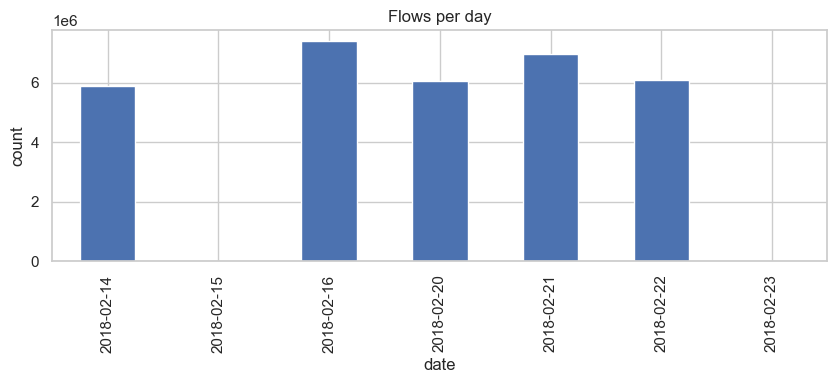

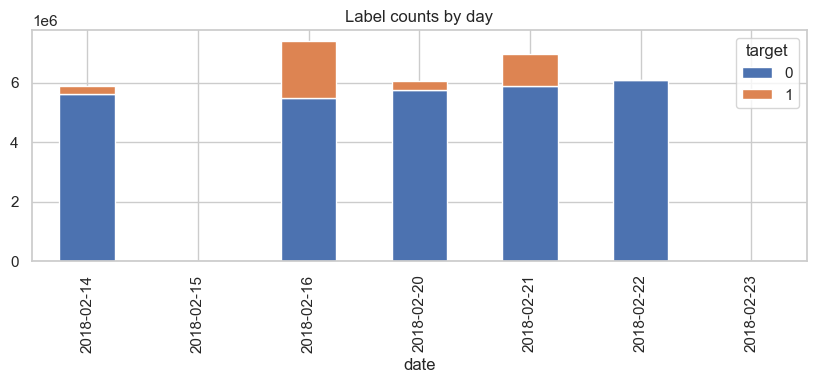

In [5]:
# visualisation
# B1: flows over time (raw counts / day)
tmp = df.copy()
tmp['date'] = tmp['Timestamp'].dt.date
counts = tmp.groupby('date').size()
plt.figure(figsize=(10,3)); counts.plot(kind='bar'); plt.title("Flows per day"); plt.ylabel("count"); plt.show()

# B2: label counts over time (stacked)
agg = tmp.groupby(['date', LABEL_COL]).size().unstack(fill_value=0)
agg.plot(kind='bar', stacked=True, figsize=(10,3)); plt.title("Label counts by day"); plt.show()

In [6]:
# sort and split data by time to test only on future data
df = df.sort_values("_epoch")

split_time = df["_epoch"].quantile(0.75)
train_df = df[df["_epoch"] <= split_time].reset_index(drop=True)
test_df  = df[df["_epoch"] > split_time].reset_index(drop=True)

print("Train edges:", len(train_df), "Test edges:", len(test_df))

Train edges: 24282944 Test edges: 8094120


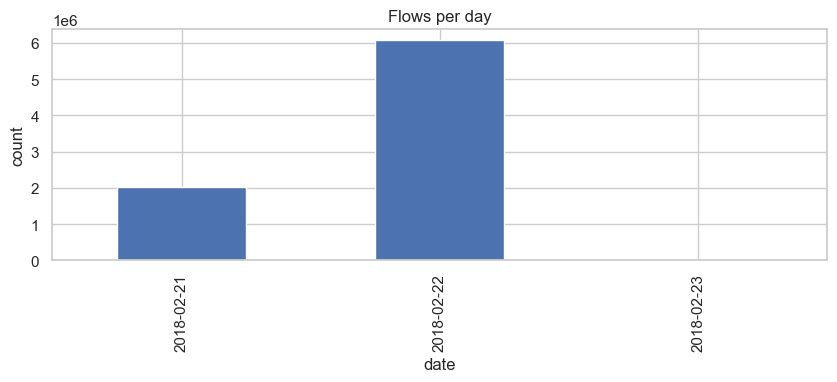

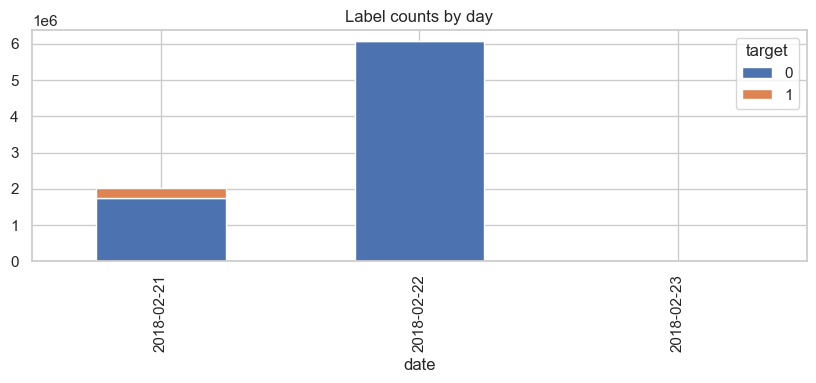

In [7]:
# visualize train_df
# B1: flows over time (raw counts / day)
tmp = test_df.copy()
tmp['date'] = tmp['Timestamp'].dt.date
counts = tmp.groupby('date').size()
plt.figure(figsize=(10,3)); counts.plot(kind='bar'); plt.title("Flows per day"); plt.ylabel("count"); plt.show()

# B2: label counts over time (stacked)
agg = tmp.groupby(['date', LABEL_COL]).size().unstack(fill_value=0)
agg.plot(kind='bar', stacked=True, figsize=(10,3)); plt.title("Label counts by day"); plt.show()

bidirectional edges stats

In [8]:
def count_bidirectional_edges(df):
    # create a helper column for fast lookup
    edge_set = set(zip(df["Src IP"], df["Dst IP"]))
    
    count = 0
    for src, dst in edge_set:
        if (dst, src) in edge_set:
            count += 1

    # each bidirectional pair counted twice (A→B and B→A)
    return count // 2

count_bidirectional_edges(df)
# C1: fraction of bidirectional pairs (raw)
edge_pairs = set(zip(df["Src IP"], df["Dst IP"]))
bid = sum(1 for (a,b) in edge_pairs if (b,a) in edge_pairs) // 2
print("Unique bidirectional pairs:", bid)
print("Total unique directed pairs:", len(edge_pairs))
print("Fraction bidirectional:", bid / max(1, len(edge_pairs)))

Unique bidirectional pairs: 4053
Total unique directed pairs: 1362832
Fraction bidirectional: 0.002973954236472287


### Make undirected graph

What: convert directed flows into unordered pairs (u,v) so A→B and B→A map to the same pair.

Why: produce a single static edge per host pair (so your aggregated static graph has one edge per pair).

In [9]:
# =====================================
# 5. Build undirected graph (canonicalized Src/Dst pairs)
# =====================================

def canonicalize(df_subset):
    """Ensure undirected edges by sorting each (Src,Dst) lexicographically."""
    src = df_subset["Src IP"].astype(str)
    dst = df_subset["Dst IP"].astype(str)
    u = np.minimum(src, dst)
    v = np.maximum(src, dst)
    df_subset = df_subset.copy()
    df_subset["u"] = u
    df_subset["v"] = v
    return df_subset

train_df = canonicalize(train_df)
test_df = canonicalize(test_df)

### Temporal → static
Aggregate edge features and labels where more than an edge exists between two nodes u,v:

• if at least one malicious edge -> take the mean of all malicious edges between u,v <br>
• else -> take mean of all (benign) edges between u,v

In [10]:
# 5.2
def build_static_graph(df):
    # Group by edge pairs
    grouped = df.groupby(["u", "v"])

    static_edges = []

    for (src, dst), group in grouped:
        if (group["target"] == 1).any():
            # Filter only malicious flows for averaging
            subset = group[group["target"] == 1]
            label = 1
        else:
            subset = group  # all benign
            label = 0
        
        # Compute mean over relevant subset
        mean_feats = subset[EDGE_COLS].mean().to_dict()
        # Keep the most recent timestamp in this subset
        latest_ts = subset["Timestamp"].max()

        mean_feats.update({
            "u": src,
            "v": dst,
            "target": label,
            "Timestamp": latest_ts,
            "count": len(group)  # optional: number of flows merged
        })
        static_edges.append(mean_feats)

    return pd.DataFrame(static_edges)

train_df = build_static_graph(train_df)
test_df = build_static_graph(test_df)
# print(train_df[train_df["count"] > 1].head())

visualisation

In [11]:
# D1: how many flows were aggregated per pair (if you kept 'count')
if 'count' in train_df.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(train_df['count'], bins=50, log_scale=(False, True))
    plt.title("Distribution of number of flows merged per aggregated edge (train)")
    plt.xlabel("merged flow count")
    plt.show()

# D2: label balance after aggregation
print("Train aggregated label counts:\n", train_df['target'].value_counts())
print("Test aggregated label counts:\n", test_df['target'].value_counts())

Train aggregated label counts:
 target
0    1057072
1         24
Name: count, dtype: int64
Test aggregated label counts:
 target
0    522462
1        10
Name: count, dtype: int64


In [ ]:
# check if all malicious flows are between few nodes

mal_nodes = set(train_df.loc[train_df['target'] == 1, 'u']) | set(train_df.loc[train_df['target'] == 1, 'v'])
print("Unique nodes in malicious edges:", len(mal_nodes))
print("Fraction of all nodes:", len(mal_nodes) / len(set(train_df['u']) | set(train_df['v'])))



Unique nodes in malicious edges: 16
Fraction of all nodes: 0.00018217424966980917


In [13]:
from collections import Counter

mal_src = Counter(train_df.loc[train_df['target']==1, 'u'])
mal_dst = Counter(train_df.loc[train_df['target']==1, 'v'])
print("Top malicious endpoints:")
for ip, c in (mal_src + mal_dst).most_common(10):
    print(ip, c)

Top malicious endpoints:
172.31.69.25 14
172.31.69.28 10
18.216.200.189 2
18.216.24.42 2
18.218.11.51 2
18.218.115.60 2
18.218.229.235 2
18.218.55.126 2
18.219.32.43 2
18.219.5.43 2


In [14]:
import networkx as nx
G = nx.from_pandas_edgelist(train_df[train_df['target']==1], 'u', 'v')
print(nx.info(G))
nx.draw(G, with_labels=False, node_size=100)
plt.title("Malicious edge subgraph")
plt.show()

AttributeError: module 'networkx' has no attribute 'info'

### Build node list & adjacency representation
What: map IP strings → integer node ids, create edge_index in PyG format (2 × E), duplicate each undirected edge into two directed edges for message passing, duplicate edge features/labels accordingly.

Why: PyG expects edge_index as directed edges; duplicating ensures symmetric message passing.


In [ ]:
# =====================================
# 6. Build node list, edge index, and features
# =====================================

import torch
from sklearn.preprocessing import StandardScaler

# Map IPs to node indices
nodes = pd.Index(np.unique(np.concatenate([train_df[["u","v"]].values.ravel(),
                                           test_df[["u","v"]].values.ravel()])))
node_to_idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)
print("Total unique nodes:", N)

Total unique nodes: 107583


In [ ]:
# Build edge index (undirected)
u_idx = [node_to_idx[x] for x in train_df["u"]]
v_idx = [node_to_idx[x] for x in train_df["v"]]
edge_index_train = np.vstack([u_idx + v_idx, v_idx + u_idx])  # both directions
edge_attr_train = np.repeat(train_df[EDGE_COLS].values, 2, axis=0)
y_train = np.repeat(train_df[LABEL_COL].values, 2, axis=0)

# Standardize edge features
# What: zero mean, unit variance on each edge feature using train statistics.
# Why: neural nets train faster/safer when features are scaled consistently; use train stats only to avoid leakage.
scaler = StandardScaler()
edge_attr_train = scaler.fit_transform(edge_attr_train)

# Prepare test edges
u_idx_t = [node_to_idx.get(x, -1) for x in test_df["u"]]
v_idx_t = [node_to_idx.get(x, -1) for x in test_df["v"]]
edge_index_test = np.vstack([u_idx_t + v_idx_t, v_idx_t + u_idx_t])
edge_attr_test = np.repeat(test_df[EDGE_COLS].values, 2, axis=0)
edge_attr_test = scaler.transform(edge_attr_test)
y_test = np.repeat(test_df[LABEL_COL].values, 2, axis=0)

visualisation

In [ ]:
# F1: histograms of a few edge features (train)
edge_attr_df = pd.DataFrame(edge_attr_train, columns=EDGE_COLS)
edge_attr_df.iloc[:, :6].hist(bins=40, figsize=(12,4))
plt.suptitle("Example scaled edge features distributions (train)")
plt.show()

# F2: class-conditional distributions for a single feature
feat = EDGE_COLS[0]
plt.figure(figsize=(6,3))
sns.kdeplot(train_df[train_df['target']==0][feat], label='benign', bw_adjust=1.2)
sns.kdeplot(train_df[train_df['target']==1][feat], label='malicious', bw_adjust=1.2)
plt.title(f"Feature {feat} by class")
plt.legend(); plt.show()

In [11]:
# =====================================
# 7. Build node features (mean of incident edge features)
# =====================================

node_feats = np.zeros((N, len(EDGE_COLS)), dtype=np.float32)
node_counts = np.zeros(N, dtype=np.int32)

for _, row in train_df.iterrows():
    u = node_to_idx[row["u"]]
    v = node_to_idx[row["v"]]
    feats = row[EDGE_COLS].values.astype(np.float32)
    node_feats[u] += feats
    node_feats[v] += feats
    node_counts[u] += 1
    node_counts[v] += 1

mask = node_counts > 0
node_feats[mask] /= node_counts[mask][:, None]

# Convert all to torch tensors
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.tensor(node_feats, dtype=torch.float32, device=DEVICE)
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long, device=DEVICE)
edge_attr_train = torch.tensor(edge_attr_train, dtype=torch.float32, device=DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)

edge_index_test = torch.tensor(edge_index_test, dtype=torch.long, device=DEVICE)
edge_attr_test = torch.tensor(edge_attr_test, dtype=torch.float32, device=DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

print(f"x: {x.shape}, train edges: {edge_index_train.shape[1]}, test edges: {edge_index_test.shape[1]}")

x: torch.Size([107583, 13]), train edges: 2114192, test edges: 1044944


visualization

In [ ]:
# G1: node degree (train graph) histogram
from collections import Counter
u_idx = [node_to_idx[x] for x in train_df['u']]
v_idx = [node_to_idx[x] for x in train_df['v']]
deg = Counter(u_idx + v_idx)
deg_vals = np.array(list(deg.values()))
plt.figure(figsize=(6,3)); sns.histplot(deg_vals, bins=50, log_scale=(False, True)); plt.title("Node degree distribution (train aggregated)"); plt.show()

# G2: sample node feature vectors (PCA 2D)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mask = node_counts>0
p = pca.fit_transform(node_feats[mask])
plt.figure(figsize=(6,4)); plt.scatter(p[:,0], p[:,1], s=2); plt.title("PCA of node features (train)"); plt.show()

In [12]:
# =====================================
# 8. Define the GCN + Edge-MLP model
# =====================================

from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F

class EdgeGCN(nn.Module):
    def __init__(self, in_channels, edge_dim, hidden=64, out_node=32):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, out_node)
        self.edge_mlp = nn.Sequential(
            nn.Linear(2*out_node + edge_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x, edge_index, edge_attr):
        h = F.relu(self.conv1(x, edge_index))
        h = self.conv2(h, edge_index)
        src, dst = edge_index
        h_src, h_dst = h[src], h[dst]
        z = torch.cat([h_src, h_dst, edge_attr], dim=1)
        return self.edge_mlp(z).squeeze()

In [ ]:
# =====================================
# 9. Train the model
# =====================================

model = EdgeGCN(in_channels=x.shape[1], edge_dim=edge_attr_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum().clamp(min=1)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

loss_history = []
acc_history = []

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    logits = model(x, edge_index_train, edge_attr_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        preds = (torch.sigmoid(logits) > 0.5).float()
        acc = (preds == y_train).float().mean().item()
    loss_history.append(loss.item())
    acc_history.append(acc)
    print(f"Epoch {epoch+1}: loss={loss.item():.4f}, acc={acc:.4f}")

Epoch 1: loss=64874.3984, acc=0.4223
Epoch 2: loss=8054637.0000, acc=1.0000
Epoch 3: loss=3669250.7500, acc=1.0000
Epoch 4: loss=592457.7500, acc=1.0000
Epoch 5: loss=691063.6875, acc=0.0000
Epoch 6: loss=383222.5625, acc=0.0000
Epoch 7: loss=644317.0000, acc=1.0000
Epoch 8: loss=76865.7344, acc=0.5976
Epoch 9: loss=355926.9062, acc=0.0291
Epoch 10: loss=606286.8125, acc=1.0000


Visualisation

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.plot(loss_history); plt.title("Train loss")
plt.subplot(1,2,2); plt.plot(acc_history); plt.title("Train acc"); plt.show()

In [14]:
# =====================================
# 10. Evaluate on test set
# =====================================

from sklearn.metrics import confusion_matrix

model.eval()
with torch.no_grad():
    logits_test = model(x, edge_index_test, edge_attr_test)
    probs = torch.sigmoid(logits_test).cpu().numpy()
    preds = (probs > 0.5).astype(int)
    y_true = y_test.cpu().numpy().astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, preds))
print("\nClassification Report:")
print(classification_report(y_true, preds, digits=4))
print("ROC-AUC:", roc_auc_score(y_true, probs))


Confusion Matrix:
[[360422 684502]
 [     3     17]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.3449    0.5129   1044924
           1     0.0000    0.8500    0.0000        20

    accuracy                         0.3449   1044944
   macro avg     0.5000    0.5975    0.2565   1044944
weighted avg     1.0000    0.3449    0.5129   1044944

ROC-AUC: 0.5974656530044289


Visualisation

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# I1: confusion matrix heatmap
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion matrix"); plt.show()

# I2: ROC
RocCurveDisplay.from_predictions(y_true, probs); plt.show()

# I3: PR curve
PrecisionRecallDisplay.from_predictions(y_true, probs); plt.show()

# I4: histogram of predicted probabilities per class
plt.figure(figsize=(6,3))
sns.histplot(probs[y_true==0], label='benign', stat='density', bins=100, alpha=0.6)
sns.histplot(probs[y_true==1], label='malicious', stat='density', bins=100, alpha=0.6)
plt.legend(); plt.title("Predicted prob distribution by class"); plt.show()

In [ ]:
prec, rec, thr = precision_recall_curve(y_true, probs)
f1s = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("best PR-F1 thr:", best_thr, "F1:", f1s[best_idx])